http://ufldl.stanford.edu/housenumbers/
### format 1
After unzipping the .tar.gz file, the train folder have 33402 .png files, 1 digitStruct.mat file. Using Matlab open this .mat file, I get a 1* 33402 struct. Each struct has 2 fields: name, bbox. name is png file name; bbox is the location of blue box, which is represent by a struct with 5 fields: height, left, top, width, label. After some experiment, I figure out how to show the digits in the blue box:
```python
import cv2
path = 'train/1.png'
image = cv2.imread(path)
cropped = image[top:top+height, left:left+width]
cv2.imshow("cropped", cropped)
cv2.waitKey(0)
```

So the pixel size for the actual input is height*width. It will need resizing for practical use. Another thing is convert color to grey scale.

### format 2
The train32x32.mat has 2 variables, X has a shape of 32\*32\*3\*73257, y is just 73257 digit labels. Note that y has 10 but not 0. So actually format 2 is single digit recognition, which can serve as inital experiments if needed.

---
# using format 2
1. read data, convert 3D data to 2D data
2. show image to see whether data is good
3. use sklearn model as a baseline test (This turn out to be a misleading idea)
4. use one hidden softmax layer neural network, get 65% accuracy on test dataset.

In [14]:
import numpy as np
import scipy.io
# train_mat = scipy.io.loadmat('train_32x32.mat')  # dict.key() ['y', 'X', '__version__', '__header__', '__globals__']

def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  return 0.2989 * r + 0.5870 * g + 0.1140 * b

def mat2data(matfile):
  mat = scipy.io.loadmat(matfile)
  Xdata = mat['X']
  ydata = mat['y']
  size = Xdata.shape   # (32,32,3,73257)
  print 'size = {0}'.format(size)
  image_size_x = size[0]
  image_size_y = size[0]
  num_samples = size[3]

  depth = 255.0  # pixel depth
  dataset = np.ndarray(shape=(num_samples, image_size_x, image_size_y),dtype=np.float32)
  labels = np.ndarray(shape=(num_samples,),dtype=np.int8)
  for i in range(num_samples):
    dataset[i,:,:] = rgb2gray(Xdata[:,:,:,i]) /depth - 0.5  # 3D-2D and normalize
    labels[i] = ydata[i][0] % 10
  return dataset, labels

X_train,y_train = mat2data('train_32x32.mat')
X_test, y_test  = mat2data('test_32x32.mat') 
with open('train_test_32x32.pickle','wb') as pf:
  pickle.dump(((X_train,y_train),(X_test, y_test)), pf, pickle.HIGHEST_PROTOCOL)  

size = (32, 32, 3, 73257)
size = (32, 32, 3, 26032)


In [2]:
print X_train.shape
print y_train.shape

(73257, 32, 32)
(73257,)


### show image

3


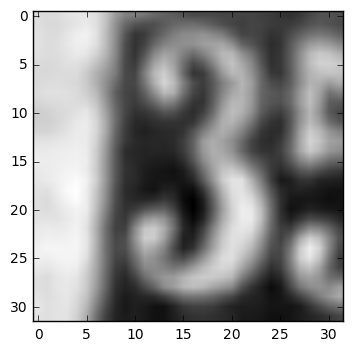

In [3]:
from matplotlib import pyplot as plt
% matplotlib inline
index = np.random.randint(73257)
image = X_train[index]
print y_train[index]
plt.imshow(image,cmap='gray')
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()

nsamples, nx, ny = X_train.shape
X1 = X_train.reshape((nsamples,nx*ny))
y1 = y_train

nsamples, nx, ny = X_test.shape
X2 = X_test.reshape((nsamples,nx*ny))
y2 = y_test

from time import time
t0 = time()
size1 = 50000
size2 = 10000

clf.fit(X1[0:size1],y1[0:size1])
print(clf.score(X2[0:size2],y2[0:size2]))
print 'time cost:', time() -t0 
# 5000/1000 get 22.4% in 21 s
# 50k/10k get 23.4% in 436 s

0.2335
time cost: 436.071338892


## format 2, using neural networks, get 65% accuracy

In [15]:
nsamples, nx, ny = X_train.shape
X1 = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X2 = X_test.reshape((nsamples,nx*ny))

import numpy as np
def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)

y1 = oneHot(y_train)
y2 = oneHot(y_test)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [20]:
import tensorflow as tf
from time import time
hidden_size = 1000 # original 1024
image_size =32*32

# estimated parameters: (784+1)*1024+(1024+1)*10 = 814 k
# reduced parameters: (784+1)*100+(100+1)*10 = 80 k

X = tf.placeholder(tf.float32,shape=(None, image_size))
y = tf.placeholder(tf.float32, shape=(None, 10))

# input layer to hidden layer
weights1 = tf.Variable(tf.truncated_normal([image_size, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))
logits1 = tf.matmul(X, weights1) + biases1
hidden1 = tf.nn.relu(logits1)

# hidden layer to output layer
weights = tf.Variable(tf.truncated_normal([hidden_size, 10]))
biases = tf.Variable(tf.zeros([10]))
logits = tf.matmul(hidden1, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,y)) +\
  0.01 * tf.nn.l2_loss(weights1) + 0.01 * tf.nn.l2_loss(weights)  # L2 regulation
optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# Predictions for the training, validation, and test data.
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# ------------------------------- execute phase -----------------  
t0= time()
feed_valid = {X: X2, y: y2}
feed_test  = feed_valid
  
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
print("Initialized")

num_steps = 8001
batch_size = 128  
for step in range(num_steps):
  offset = (step * batch_size) % (nsamples - batch_size)
  batch_data = X1[offset:(offset + batch_size), :]
  batch_labels = y1[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels}
  sess.run(optimizer,feed_dict= feed_train)
  lo = sess.run(loss, feed_dict= feed_train)
  if (step % 500 == 0):

    print("Step = {0:4d}, loss = {1:5.2f},Valid accuracy ={2:g}".
          format(step,lo, sess.run(accuracy,feed_dict=feed_valid)))

print("Test accuracy: {0:g}".format(sess.run(accuracy,feed_dict=feed_test)))
print('Time cost:', time()-t0) 
# 0.1 rate, 4001 steps, 128 batch, get 64 % at 16 seconds for hidden_size =100
# 0.1 rate, 4001 steps, 128 batch, get 66 % at 90 seconds for hidden_size = 1000
# 0.1 rate, 8001 steps, 128 batch, get 65 % at 180 seconds for hidden_size = 1000
sess.close()
import os
os.system('say "your program has finished"')

Initialized
Step =    0, loss = 4146.81,Valid accuracy =0.113399
Step =  500, loss = 1461.74,Valid accuracy =0.562154
Step = 1000, loss = 536.64,Valid accuracy =0.63687
Step = 1500, loss = 198.02,Valid accuracy =0.684235
Step = 2000, loss = 73.86,Valid accuracy =0.690957
Step = 2500, loss = 28.20,Valid accuracy =0.669983
Step = 3000, loss = 11.45,Valid accuracy =0.664951
Step = 3500, loss =  5.19,Valid accuracy =0.65527
Step = 4000, loss =  3.11,Valid accuracy =0.659496
Step = 4500, loss =  2.17,Valid accuracy =0.650776
Step = 5000, loss =  1.87,Valid accuracy =0.657383
Step = 5500, loss =  1.73,Valid accuracy =0.660456
Step = 6000, loss =  1.66,Valid accuracy =0.6434
Step = 6500, loss =  1.49,Valid accuracy =0.650353
Step = 7000, loss =  1.74,Valid accuracy =0.655309
Step = 7500, loss =  1.64,Valid accuracy =0.659266
Step = 8000, loss =  1.61,Valid accuracy =0.647972
Test accuracy: 0.647972
('Time cost:', 179.3168969154358)


0

---
# using format 1, get 70% accuracy

## my plan:
1. read mat file to usable data format, pickle dump
2. crop image and resize to 28*28 image
3. reformat to trainable dataset
4. train single-digit dataset
5. test on test dataset

### step 1, read mat file

In [84]:
import numpy as np
import cPickle as pickle
import h5py

#f = h5py.File('train/digitStruct.mat')
f = h5py.File('test/digitStruct.mat')

metadata= {}
metadata['height'] = []
metadata['label'] = []
metadata['left'] = []
metadata['top'] = []
metadata['width'] = []

def print_attrs(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(int(obj[0][0]))
    else:
        for k in range(obj.shape[0]):
            vals.append(int(f[obj[k][0]][0][0]))
    metadata[name].append(vals)

for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(print_attrs)
    
#with open('train_metadata.pickle','wb') as pf:
with open('test_metadata.pickle','wb') as pf:
  pickle.dump(metadata, pf, pickle.HIGHEST_PROTOCOL)    

In [64]:
count = 0
for i in range(13068):                # 2483, 8356, 2081, 146, 2,0 = 13068 test data
  length = len(metadata['width'][i])  # 5137,18130, 8691, 1434,9,1 = 33402 train data                                  
  if length == 6:
    count +=1
print count

0


### step 2, crop image

In [29]:
import cPickle as pickle
with open('test_metadata.pickle', 'rb') as f:
    metadata = pickle.load(f)

In [30]:
index = 2
path = 'test/{0}.png'.format(index+1)
from IPython.display import display, Image
display(Image(filename = path))

In [31]:
digit_order = 0
top = metadata['top'][index][digit_order]
height = metadata['height'][index][digit_order]
left = metadata['left'][index][digit_order]
width = metadata['width'][index][digit_order]
label = metadata['label'][index][digit_order]

import cv2
image = cv2.imread(path)
cropped = image[top:top+height, left:left+width]
print top,height,left,width,label

6 16 61 11 6


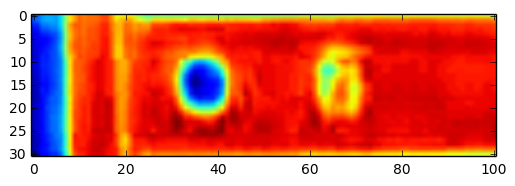

In [32]:
from matplotlib import pyplot as plt
% matplotlib inline
plt.imshow(image[:,:,0])
#plt.imshow(cropped[:,:,0])
plt.show()

In [33]:
print image.shape
print cropped.shape
print label

(31, 101, 3)
(16, 11, 3)
6


In [34]:
def rgb2gray(rgb):
  r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
  return 0.2989 * r + 0.5870 * g + 0.1140 * b

In [35]:
gray_image = rgb2gray(cropped )

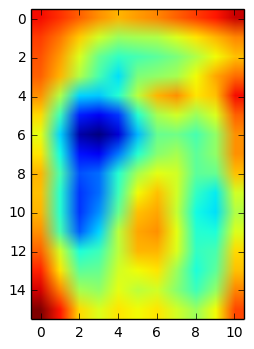

In [36]:
from matplotlib import pyplot as plt
% matplotlib inline
#plt.imshow(gray_image,cmap='gray')
plt.imshow(cropped[:,:,0])
plt.show()

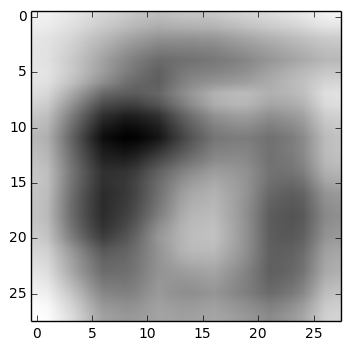

In [37]:
resize_image = cv2.resize(gray_image,(28,28))
plt.imshow(resize_image,cmap='gray')
plt.show()

### step 3, reformat to trainable dataset

the order of processing a image is:
1. convert png file to 3d numpy array
2. crop to single digit
3. convert to 2d numpy array (greyscale)
4. resize to 28 * 28 array
5. normalize the values in the range of [-0.5,0.5]
6. pickle dump into pickle file

In [28]:
image_num = 33402
count = 0
for i in range(image_num):                
  digit_num += len(metadata['width'][i])  
print count

73257


In [ ]:
import cPickle as pickle
#with open('train_metadata.pickle', 'rb') as f:
with open('test_metadata.pickle', 'rb') as f:  
    metadata = pickle.load(f)

import numpy as np 
import cv2
#image_num = 33402
#sample_num = 73257
image_num =  13068
sample_num = 26032

dataset = np.ndarray(shape=(sample_num, 28, 28),dtype=np.float32)
lables = np.ndarray(shape=(sample_num, ),dtype=np.int)

def crop(image, i,j):
  top = metadata['top'][i][j]
  height = metadata['height'][i][j]
  left = metadata['left'][i][j]
  width = metadata['width'][i][j]
  if left < 0:
    left, width = 0, width+left
  
  return image[top:top+height, left:left+width]

depth = 255.0  # pixel depth
for i in range(image_num):
  #path = 'train/{0}.png'.format(i+1)
  path = 'test/{0}.png'.format(i+1)
  image = cv2.imread(path)
  num = len(metadata['width'][i])  
  for j in range(num):
    crop_image = crop(image,i,j)
    gray_image = rgb2gray(crop_image)
    #print i,j  # find (250,0) has left value of -1
    resize_image = cv2.resize(gray_image,(28,28))
    normal_image = resize_image/depth -0.5
    dataset[count,:,:] = normal_image
    lables[count] = metadata['label'][i][j] % 10

#with open('train_dataset_labels.pickle','wb') as pf:
with open('test_dataset_labels.pickle','wb') as pf:  
  pickle.dump((dataset,lables), pf, pickle.HIGHEST_PROTOCOL)  
  
del metadata # clean cache

## step 4, train single digit dataset

### use logistic regression model to train and test

In [13]:
import cPickle as pickle
with open('train_dataset_labels.pickle','rb') as f:
  (dataset,labels) = pickle.load(f)

# from sklearn.model_selection import train_test_split   # v 0.18
from sklearn.cross_validation import train_test_split    # v 0.14
X1, X2,y1,y2 = train_test_split(dataset, labels, test_size=0.3, random_state=0)

#from sklearn.linear_model import LogisticRegression
#clf=LogisticRegression()
from sklearn.svm import SVC
clf = SVC()

nsamples, nx, ny = X1.shape
X1 = X1.reshape((nsamples,nx*ny))

nsamples, nx, ny = X2.shape
X2 = X2.reshape((nsamples,nx*ny))


from time import time
t0 = time()
size1 = 50000
size2 = 10000

clf.fit(X1[0:size1],y1[0:size1])
print(clf.score(X2[0:size2],y2[0:size2]))
print 'time cost:', time() -t0 
# logistic regression
# 5000/1000 get 24.9 % in 19 s
# 50k/10k get 27.4% in 397 s
# svm
# 5k/1k get 16% in 38 s
# 50k/10k get 23.9 % in 4000 s
import os
os.system('say "your program has finished"')

0.2386
time cost: 3983.77952099


0

### conclusion: 
The low accuracy is probably due to:
1. the background is not clean
2. the resizing operation blurs the images.
3. **shallow machine learning models do a poor job in catching the patterns of ugly handwritting**

### use logistic model train on mnist but test on SVHN
*Conclusion: The model trained by mnist doesn't apply to SVHN.*

In [71]:
from six.moves import cPickle 
import gzip
with gzip.open('mnist.pkl.gz', 'rb') as f:
    training_data, validation_data, test_data = cPickle.load(f)
[X_train, y_train] = training_data
[X_valid, y_valid] = validation_data
[X_test, y_test] = test_data

from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()

from time import time
t0 = time()

clf.fit(X_train,y_train)
print 'validation accuracy:',clf.score(X_valid,y_valid)
print 'test accuracy:',clf.score(X_test,y_test)
print 'time cost:', time() -t0 

validation accuracy: 0.9217
test accuracy: 0.92
time cost: 70.0851459503


In [75]:
print 'SVHN accuracy:', clf.score(dataset.reshape(-1,784),labels)

 SVHN accuracy: 0.117313021281


### use convolusion nets to train

In [3]:
import cPickle as pickle
with open('train_dataset_labels.pickle','rb') as f:
  (X_train,y_train) = pickle.load(f)
with open('train_dataset_labels.pickle','rb') as f:
  (X_test,y_test) = pickle.load(f)
  
nsamples, nx, ny = X_train.shape
X1 = X_train.reshape((nsamples,nx*ny))

nsamples, nx, ny = X_test.shape
X2 = X_test.reshape((nsamples,nx*ny))

import numpy as np
def oneHot(lables):
  return (np.arange(10) == lables[:,None]).astype(np.float32)

y1 = oneHot(y_train)
y2 = oneHot(y_test)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [5]:
import tensorflow as tf

from time import time


hidden_size = 100 # original 1024
# estimated parameters: (784+1)*1024+(1024+1)*10 = 814 k
# reduced parameters: (784+1)*100+(100+1)*10 = 80 k

X = tf.placeholder(tf.float32,shape=(None, 784))
y = tf.placeholder(tf.float32, shape=(None, 10))

# input layer to hidden layer
weights1 = tf.Variable(tf.truncated_normal([784, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))
logits1 = tf.matmul(X, weights1) + biases1
hidden1 = tf.nn.relu(logits1)

# hidden layer to output layer
weights = tf.Variable(tf.truncated_normal([hidden_size, 10]))
biases = tf.Variable(tf.zeros([10]))
logits = tf.matmul(hidden1, weights) + biases

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits,y)) +\
  0.01 * tf.nn.l2_loss(weights1) + 0.01 * tf.nn.l2_loss(weights)  # L2 regulation
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Predictions for the training, validation, and test data.
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# ------------------------------- execute phase -----------------  
t0= time()
feed_valid = {X: X2, y: y2}
feed_test  = feed_valid
  
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
print("Initialized")

num_steps = 8001
batch_size = 128  
for step in range(num_steps):
  offset = (step * batch_size) % (nsamples - batch_size)
  batch_data = X1[offset:(offset + batch_size), :]
  batch_labels = y1[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels}
  sess.run(optimizer,feed_dict= feed_train)
  lo = sess.run(loss, feed_dict= feed_train)
  if (step % 500 == 0):

    print("Step = {0:4d}, loss = {1:5.2f},Valid accuracy ={2:g}".
          format(step,lo, sess.run(accuracy,feed_dict=feed_valid)))

print("Test accuracy: {0:g}".format(sess.run(accuracy,feed_dict=feed_test)))
print('Time cost:', time()-t0) 
# 0.1 rate, 4001 steps, 128 batch, get 71 % at 17 seconds
# 0.1 rate, 8001 steps, 128 batch, no improvement
sess.close()

Initialized
Step =    0, loss = 343.30,Valid accuracy =0.151494
Step =  500, loss = 187.15,Valid accuracy =0.456775
Step = 1000, loss = 113.07,Valid accuracy =0.590415
Step = 1500, loss = 69.04,Valid accuracy =0.643324
Step = 2000, loss = 42.45,Valid accuracy =0.677532
Step = 2500, loss = 26.09,Valid accuracy =0.690637
Step = 3000, loss = 16.53,Valid accuracy =0.6982
Step = 3500, loss = 10.65,Valid accuracy =0.701407
Step = 4000, loss =  7.18,Valid accuracy =0.710935
Step = 4500, loss =  5.09,Valid accuracy =0.702308
Step = 5000, loss =  3.59,Valid accuracy =0.707741
Step = 5500, loss =  2.89,Valid accuracy =0.709379
Step = 6000, loss =  2.31,Valid accuracy =0.707154
Step = 6500, loss =  1.98,Valid accuracy =0.708192
Step = 7000, loss =  1.82,Valid accuracy =0.705298
Step = 7500, loss =  1.85,Valid accuracy =0.707086
Step = 8000, loss =  1.66,Valid accuracy =0.712983
Test accuracy: 0.712983
('Time cost:', 33.70896601676941)


In [ ]:
import tensorflow as tf
from time import time 

# Weight Initialization
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Convolution and Pooling
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

X = tf.placeholder(tf.float32, shape=[None, 784])
y = tf.placeholder(tf.float32, shape=[None, 10]) # labels

# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32]) # 2D patch sizes, input/output channels
b_conv1 = bias_variable([32])

x_image = tf.reshape(X, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)  ## image size reduce to 7*7
# --------------------------------------------------------------------------------
# Second Convolutional Layer
#W_conv2 = weight_variable([5, 5, 32, 64])
#b_conv2 = bias_variable([64])

#h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
#h_pool2 = max_pool_2x2(h_conv2)  # image size reduce to 14*14
# ---------------------------------------------------------------------------------
# Densely Connected Layer
W_fc1 = weight_variable([14 * 14 * 32, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool1, [-1, 14*14*32])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
# ---------------------------------------------------------------------------------
# Readout Layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)  # more sophisticated ADAM optimizer

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

feed_test  = {X: X2, y: y2, keep_prob: 1.0}

# exectue phase ====================================================================
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
print("Initialized")
t0 = time()
batch_size = 50
step_num = 2001
for step in range(step_num): # 
  offset = (step * batch_size) % (nsamples - batch_size)
  batch_data = X1[offset:(offset + batch_size), :]
  batch_labels = y1[offset:(offset + batch_size), :]
  
  feed_train = {X: batch_data, y: batch_labels,keep_prob: 0.5}
  sess.run(train_step,feed_dict = feed_train)
  
  if step % 20 == 0:
    test_accuracy = sess.run(accuracy,feed_dict = feed_test) # keep_prob in feed_dict to control the dropout rate.
    lo = sess.run(loss,feed_dict = feed_test)
    print("step {0:d}, loss = {1:.5g}, test accuracy {2:g}".format(step, lo, test_accuracy))
    print("time cost:",time()-t0)

print("test accuracy {0:g}".format(sess.run(accuracy,feed_dict = feed_test)))
print("time cost:",time()-t0) 
# 2000 step, 50 batch_size,  get 72.8% in 1800 seconds

import os
os.system('say "your program has finished"')